# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [20]:
# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [21]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [23]:
# TODO: Define your transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

#NOTE: the below resize and crop are to change image to 224 by 224 exactly
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])


#NOTE: Reducing batch size from 64 to 32 reduces memory usage for each batch (so no cuda memory loss)
# TODO: Load the datasets with ImageFolder
train_images = datasets.ImageFolder(train_dir,transform = train_transforms)
valid_images = datasets.ImageFolder(valid_dir, transform = test_transforms)
test_images = datasets.ImageFolder(valid_dir, transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_images,batch_size = 32, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_images, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(test_images, batch_size = 32, shuffle = True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [27]:
#JUST AN EXPERIMENT to see how many input features other models have
model_ = models.alexnet(pretrained = True)
model_

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 114771316.10it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [25]:
#Load pretrained model, freeze features and change layer info
model = models.vgg16(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
#This part (from... import and "with active_session" is to make sure it doesn't stop for long running processes
#THIS IS ACTUAL TRAINING STEP

from workspace_utils import active_session

with active_session():
    # TODO: Build and train your network
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    for param in model.parameters():
        param.require_grad = False
    #OLD classifiers that I tried:
    #classifier = nn.Sequential(nn.Linear(25088,4096), nn.ReLU(), nn.Dropout(p=0.2), nn.Linear(4096,1000), nn.ReLU(),
                               #nn.Dropout(p=0.2), nn.Linear(1000,500), nn.ReLU(),nn.Dropout(p=0.2),nn.Linear(500,200),nn.ReLU(),nn.Dropout(p=0.2),
                               #nn.Linear(200,2), nn.LogSoftmax(dim=1))

    #classifier = nn.Sequential(nn.Linear(25088,4096), nn.ReLU(), nn.Dropout(p=0.2), nn.Linear(4096,1000), nn.ReLU(),
                               #nn.Dropout(p=0.2), nn.Linear(1000,500), nn.ReLU(),nn.Dropout(p=0.2),
                               #nn.Linear(500,102), nn.LogSoftmax(dim=1))

    #classifier = nn.Sequential(nn.Linear(25088,10000),nn.ReLU(),nn.Dropout(p=0.2),
                               #nn.Linear(10000,4096),nn.ReLU(), nn.Dropout(p=0.2),
                               #nn.Linear(4096, 102),nn.LogSoftmax(dim=1))
    #BEST classifier:
    classifier = nn.Sequential(nn.Linear(25088,500), nn.ReLU(), nn.Dropout(p=0.2),
                               nn.Linear(500,102),nn.LogSoftmax(dim=1))

    model.classifier = classifier

    #Now, ready to train the classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0003)

    
    epoch = 2
    running_loss = 0
    steps = 0
    print_every = 30
    model.to(device)
    for e in range(epoch):
        for images,labels in trainloader:
            #Move the images and labels to gpu, and increment steps
            images,labels = images.to(device),labels.to(device)
            steps+=1

            #Find output and use backpropagation to update weights
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()

        #Every 30 batches of training set, run the whole validation set and ensure that losses are decreasing
            if steps%print_every == 0:
                accuracy = 0
                test_loss = 0
                model.eval()
                for images,labels in validloader:
                    images,labels = images.to(device),labels.to(device)
                    #First find output and loss
                    out = model(images)
                    loss = criterion(out,labels)
                    test_loss+=loss.item()

                    #Then find actual probabilities of each output class to then calculate accuracy
                    ps = torch.exp(out)
                    top_p, top_class = ps.topk(1,dim=1)
                    equals = top_class==labels.view(*top_class.shape)
                    accuracy+=torch.mean(equals.type(torch.FloatTensor))

                print(f"Epoch {e+1}/{epoch}.."
                      f"Training Loss: {running_loss/print_every:.3f}.."
                      f"Test Loss: {test_loss/len(validloader):.3f}.."
                      f"Test Accuracy: {accuracy/len(validloader):.3f}")
                
                running_loss = 0
                model.train()


Epoch 1/2..Training Loss: 4.045..Test Loss: 3.048..Test Accuracy: 0.373
Epoch 1/2..Training Loss: 2.975..Test Loss: 2.162..Test Accuracy: 0.503
Epoch 1/2..Training Loss: 2.361..Test Loss: 1.480..Test Accuracy: 0.655
Epoch 1/2..Training Loss: 2.112..Test Loss: 1.237..Test Accuracy: 0.681
Epoch 1/2..Training Loss: 1.716..Test Loss: 0.937..Test Accuracy: 0.787
Epoch 1/2..Training Loss: 1.467..Test Loss: 0.765..Test Accuracy: 0.816
Epoch 2/2..Training Loss: 1.341..Test Loss: 0.732..Test Accuracy: 0.814
Epoch 2/2..Training Loss: 1.222..Test Loss: 0.643..Test Accuracy: 0.831
Epoch 2/2..Training Loss: 1.039..Test Loss: 0.597..Test Accuracy: 0.843
Epoch 2/2..Training Loss: 1.083..Test Loss: 0.529..Test Accuracy: 0.869
Epoch 2/2..Training Loss: 1.098..Test Loss: 0.558..Test Accuracy: 0.860
Epoch 2/2..Training Loss: 0.996..Test Loss: 0.527..Test Accuracy: 0.868
Epoch 2/2..Training Loss: 1.018..Test Loss: 0.488..Test Accuracy: 0.878


In [ ]:
#IF NEEDED, Continue training network based on saved model to get accuracy up to 70% or more...
from workspace_utils import active_session

with active_session():
    # TODO: Build and train your network
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load('checkpoint.pth', map_location=lambda storage, loc:storage) 
    #since say that the model is really just a checkpoint path
    actual_model = rebuild_model(checkpoint)

    for param in actual_model.parameters():
        param.require_grad = False

    #Now, ready to train the classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(actual_model.classifier.parameters(), lr = 0.0003)

    
    epoch = 1
    running_loss = 0
    steps = 0
    print_every = 30
    actual_model.to(device)
    for e in range(epoch):
        for images,labels in trainloader:
            #Move the images and labels to gpu, and increment steps
            images,labels = images.to(device),labels.to(device)
            steps+=1
            #Find output and use backpropagation to update weights
            optimizer.zero_grad()
            output = actual_model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()

     #Every 30 batches of training set, run the whole validation set and ensure that losses are decreasing
            if steps%print_every == 0:
                accuracy = 0
                test_loss = 0
                actual_model.eval()
                for images,labels in validloader:
                    images,labels = images.to(device),labels.to(device)
                    #First find output and loss
                    out = actual_model(images)
                    loss = criterion(out,labels)
                    test_loss+=loss.item()

                    #Then find actual probabilities of each output class to then calculate accuracy
                    ps = torch.exp(out)
                    top_p, top_class = ps.topk(1,dim=1)
                    equals = top_class==labels.view(*top_class.shape)
                    accuracy+=torch.mean(equals.type(torch.FloatTensor))

                print(f"Epoch {e+1}/{epoch}.."
                      f"Training Loss: {running_loss/print_every:.3f}.."
                      f"Test Loss: {test_loss/len(validloader):.3f}.."
                      f"Test Accuracy: {accuracy/len(validloader):.3f}")
                
                running_loss = 0
                actual_model.train()

                

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 95022708.88it/s] 


In [ ]:
#AGAIN, THIS PART IS FOR CONTINUATION OF TRAINING IF NECESSARY
#Now, update/save the updated checkpoint
actual_model.class_to_idx = train_images.class_to_idx
actual_model.class_to_idx

#I'm saving the whole classifier plus state (so weights) plus optimizer and epochs so far if we need to train it again later
checkpoint = {'arch':'vgg',
              'classifier':actual_model.classifier,
              'dropout':0.2,
             'input_size': 20588,
             'output_size':102,
             'class_to_idx': actual_model.class_to_idx,
             'state_dict': actual_model.state_dict(),
             'optimizer': optimizer.state_dict(),
             'epochs': epoch}
torch.save(checkpoint,'checkpoint.pth')

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# TODO: Do validation on the test set
#CHECK THIS AFTER CHECKING TRAINING code
model.eval()
accuracy = 0
test_loss = 0
for images, labels in testloader:
    images,labels = images.to(device),labels.to(device)
    #First find output and loss
    out = model(images)
    loss = criterion(out,labels)
    test_loss+=loss.item()

    #Then find actual probabilities of each output class to then calculate accuracy
    ps = torch.exp(out)
    top_p, top_class = ps.topk(1,dim=1)
    equals = top_class==labels.view(*top_class.shape)
    accuracy+=torch.mean(equals.type(torch.FloatTensor))
    
    print(f"Testing Loss: {test_loss/len(testloader)}.."
          f"Accuracy: {accuracy/len(testloader)}")


Testing Loss: 0.01770828778927143..Accuracy: 0.03365384787321091
Testing Loss: 0.02828505406012902..Accuracy: 0.06730769574642181
Testing Loss: 0.0446462298815067..Accuracy: 0.10096153616905212
Testing Loss: 0.06832698102180775..Accuracy: 0.13221153616905212
Testing Loss: 0.0827076778962062..Accuracy: 0.16706730425357819
Testing Loss: 0.10345078431642972..Accuracy: 0.20192307233810425
Testing Loss: 0.11120506490652378..Accuracy: 0.24038460850715637
Testing Loss: 0.13546957018283698..Accuracy: 0.27163460850715637
Testing Loss: 0.1537769820827704..Accuracy: 0.3040865361690521
Testing Loss: 0.16226727973956329..Accuracy: 0.3413461446762085
Testing Loss: 0.18828290987473267..Accuracy: 0.3701923191547394
Testing Loss: 0.20502521040347907..Accuracy: 0.40264421701431274
Testing Loss: 0.2186614406796602..Accuracy: 0.4375
Testing Loss: 0.23769007795132124..Accuracy: 0.47235578298568726
Testing Loss: 0.25096328957722736..Accuracy: 0.5084134340286255
Testing Loss: 0.26703491749671787..Accuracy: 0

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# TODO: Save the checkpoint 

#After training model, save as checkpoint
#First, attach mapping of class folder (since flower folder -> train/test/valid folders -> in each there are folders with..
#..pics of each species. So starting from top, folder 1,10,100,101, etc (not in order)) to an index 
#BECAUSE later, we have to invert it to assign indices to numerical classes since apparently model(image) outputs probs for..
#..outputs 0,1,2,3 etc.

model.class_to_idx = train_images.class_to_idx
model.class_to_idx

#I'm saving the whole classifier plus state (so weights) plus optimizer and epochs so far if we need to train it again later
checkpoint = {'arch':'vgg',
              'classifier':model.classifier,
              'dropout':0.2,
             'input_size': 20588,
             'output_size':102,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(),
             'epochs': epoch}
torch.save(checkpoint,'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model


def rebuild_model(checkpoint):
    #THIS FIRST BLOCK CAN BE DONE ONCE 'ARCH' IS SAVED AS VARIABLE IN CHECKPT
    #Appy to code in script in part 2
    #First load in checkpoint
    #checkpt = torch.load(checkpoint_path, map_location=lambda storage, loc:storage)
    #Then load in model and rebuild it
    #resnet18 = models.resnet18(pretrained=True)
    #alexnet = models.alexnet(pretrained=True)
    #vgg16 = models.vgg16(pretrained=True)
    #model_options = {'resnet': resnet18, 'alexnet': alexnet, 'vgg': vgg16}
    #model = model_options[checkpt['arch']]
    #model.classifier = checkpt['classifier']
    #model.load_state_dict = checkpt['state_dict']
    #model.class_to_idx = checkpt['class_to_idx']
    #return model
    
    #THE BELOW BLOCK IS WHEN ARCH ISN'T SAVED- AS IN THIS CASE, WHERE WE KNOW IT'S VGG16
    #In this notebook, we load checkpt in predict function
    #And the below loaded features are the only ones we really need for future prediction 
    model = models.vgg16(pretrained = True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    return model
#Try it
#model = rebuild_model('checkpoint.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [6]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #First resize it- keep aspect ratio but make shorter side 256..
    width,height = image.size
    if width == height:
        new_size = int(256)
        image = image.resize(new_size)
    elif width>height:
        new_size = (int(256*(width/height)), int(256))
        image = image.resize(new_size)
    else:
        new_size = (int(256), int(256*(height/width)))
    
    #Then crop out center (so we want this center piece)
    left = (width-224)/2
    right = (width+224)/2
    upper = (height-224)/2
    lower = (height+224)/2
    image = image.crop((left,upper,right,lower))
    
    #Then convert to values between 0 and 1
    np_image = np.array(image)
    np_image = np_image/np.max(np_image)
    
    #Then normalize
    np_image[0] =(np_image[0]-0.485)/0.229
    np_image[1] = (np_image[1]-0.456)/0.224
    np_image[2] = (np_image[2]-0.406)/0.225
    
    #Change dimensions
    np_image = np_image.transpose(2,0,1)
    
    #Convert to FloatTensor and return
    tensor_image = torch.FloatTensor(np_image)
    return tensor_image
    
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [7]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [13]:
from PIL import Image
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():
        image_tensor = process_image(Image.open(image_path))
        image_tensor = image_tensor.unsqueeze_(0)
        #Convert to float tensor..
        image_tensor = image_tensor.type(torch.FloatTensor)
        
        #Then load checkpoint, rebuilt model 
        checkpoint = torch.load(model,map_location=lambda storage, loc:storage)
        actual_model = rebuild_model(checkpoint)
        #Calculate output probs, and top p's and top classes
        probs = torch.exp(actual_model(image_tensor))
        top_p,top_class = probs.topk(topk,dim=1) #I don't know if we need dim here because the output should just be a 1d array with 102 probs
        
        top_class = top_class.numpy() #Convert indices to numpy array 
        #..so we need to invert the previously defined class_to_idx to get actual class numerical label..
        #then use the cat json file to convert to actual species name
        
        idx_to_class = {v:k for k,v in actual_model.class_to_idx.items()}
        #top_class = top_class.data.numpy()[0].tolist()
        actual_classes = [idx_to_class[i] for i in top_class[0]]
        
        top_p = top_p.numpy() #Convert probabilities tensor to numpy array
        
        return top_p,actual_classes
        
        
#Try it
predict('flowers/train/10/image_07086.jpg','checkpoint.pth')#checkpoint.pth from way above (saving model)

(array([[ 0.16295075,  0.08486424,  0.06382743,  0.05561496,  0.0384394 ]], dtype=float32),
 ['12', '51', '70', '14', '52'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

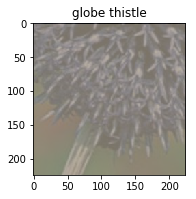

([<matplotlib.axis.YTick at 0x7eff1edb7978>,
 <a list of 5 Text yticklabel objects>)

In [ ]:
%matplotlib inline
%config InLineBackend.figure_format = 'retina'


# TODO: Display an image along with the top 5 classes
#Predict top 5 classes and plot
probs, classes = predict('flowers/train/10/image_07088.jpg','checkpoint.pth')
actual_labels = [cat_to_name[x] for x in classes]
probs = probs[0].tolist()

#PLOT both image and graph in one 
#First plot image
fig = plt.figure()
plt.subplot(1,2,1)
ax1 = fig.add_axes()
image_tensor = process_image(Image.open('flowers/train/10/image_07088.jpg'))
ax1 = imshow(image_tensor,ax = plt)
ax1.title(cat_to_name['10'])
ax1.show()

#Then plot graph 
plt.subplot(1,2,2)
ax2 = fig.add_axes()
y = np.arange(len(actual_labels))
plt.barh(y,probs,align = 'center',alpha = 0.5)
plt.yticks(y,actual_labels)


